# Setup the Env


In [1]:
import sys
import os

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
/home/sagemaker-user/capstone-2024-summer/src/rachel


# Import libraries


In [2]:
# standard libraries
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt

!pip install seaborn -q
import seaborn as sns

# Download Data from S3 as needed


In [3]:
# crsp = "CRSP/crsp_2018-2023.csv"
# crsp_path = s3_download(crsp)

In [4]:
# index = "Index/security_master.csv"
# index_path = s3_download(index)

# Load the dataset

https://www.crsp.org/wp-content/uploads/guides/CRSP_US_Stock_&_Indexes_Database_Data_Descriptions_Guide.pdf


In [5]:
crsp_df = pd.read_csv(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023.csv",
    parse_dates=["date"],
)

crsp_df.head()

/tmp/ipykernel_1595/2387555262.py:1: DtypeWarning: Columns (2,5,6,9,18,19,20,22,24,49,57) have mixed types. Specify dtype option on import or set low_memory=False.
  crsp_df = pd.read_csv(


,PERMNO,date,NAMEENDT,SHRCD,EXCHCD,SICCD,NCUSIP,TICKER,COMNAM,SHRCLS,...,CFACPR,CFACSHR,OPENPRC,NUMTRD,RETX,vwretd,vwretx,ewretd,ewretx,sprtrn
0,10026,2018-01-02,NaN,11.0,3.0,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,...,1.0,1.0,152.39000,1036.0,-0.017454,0.008505,0.008471,0.011232,0.011214,0.008303
1,10026,2018-01-03,NaN,11.0,3.0,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,...,1.0,1.0,149.07001,1283.0,-0.009988,0.005856,0.005852,0.005103,0.005094,0.006399
2,10026,2018-01-04,NaN,11.0,3.0,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,...,1.0,1.0,147.77000,1138.0,0.013813,0.004001,0.003858,0.005272,0.005217,0.004029
3,10026,2018-01-05,NaN,11.0,3.0,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,...,1.0,1.0,149.74001,745.0,-0.009550,0.005804,0.005802,0.003880,0.003865,0.007034
4,10026,2018-01-08,NaN,11.0,3.0,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,...,1.0,1.0,147.77000,990.0,0.000742,0.001816,0.001802,0.000584,0.000574,0.001662


# Take a look at the columns


In [6]:
crsp_df.columns

Index(['PERMNO', 'date', 'NAMEENDT', 'SHRCD', 'EXCHCD', 'SICCD', 'NCUSIP',
       'TICKER', 'COMNAM', 'SHRCLS', 'TSYMBOL', 'NAICS', 'PRIMEXCH', 'TRDSTAT',
       'SECSTAT', 'PERMCO', 'ISSUNO', 'HEXCD', 'HSICCD', 'CUSIP', 'DCLRDT',
       'DLAMT', 'DLPDT', 'DLSTCD', 'NEXTDT', 'PAYDT', 'RCRDDT', 'SHRFLG',
       'HSICMG', 'HSICIG', 'DISTCD', 'DIVAMT', 'FACPR', 'FACSHR', 'ACPERM',
       'ACCOMP', 'SHRENDDT', 'NWPERM', 'DLRETX', 'DLPRC', 'DLRET', 'TRTSCD',
       'NMSIND', 'MMCNT', 'NSDINX', 'BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET',
       'BID', 'ASK', 'SHROUT', 'CFACPR', 'CFACSHR', 'OPENPRC', 'NUMTRD',
       'RETX', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn'],
      dtype='object')

In [7]:
crsp_df.dtypes

PERMNO               int64
date        datetime64[ns]
NAMEENDT            object
SHRCD              float64
EXCHCD             float64
                 ...      
vwretd             float64
vwretx             float64
ewretd             float64
ewretx             float64
sprtrn             float64
Length: 63, dtype: object

In [8]:
og_crsp_len = len(crsp_df)
og_crsp_cols = len(crsp_df.columns)
print("number of records:", og_crsp_len)
print("number of columns:", og_crsp_cols)

number of records: 12665502
number of columns: 63


# Null analysis


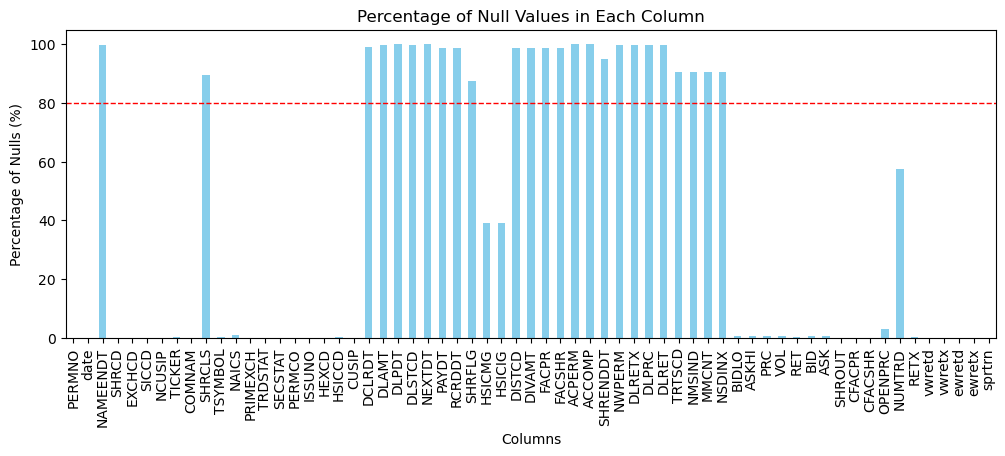

In [9]:
# Count the number of nulls in each column
null_counts = crsp_df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(crsp_df)
null_percentages = (null_counts / total_rows) * 100

# Plot the percentages as a bar plot
null_percentages.plot(kind="bar", figsize=(12, 4), color="skyblue")
plt.axhline(y=80, color="red", linestyle="--", linewidth=1)
plt.title("Percentage of Null Values in Each Column")
plt.xlabel("Columns")
plt.ylabel("Percentage of Nulls (%)")
plt.show()

## A1. Drop all columns which contains more than 80% null as they cannot be reasonably obtained or imputed.


In [10]:
og_cols = len(crsp_df.columns)
columns_to_drop = null_percentages[null_percentages > 80].index
crsp_df = crsp_df.drop(columns=columns_to_drop)
new_cols = len(crsp_df.columns)
print("num_columns_removed: ", og_cols - new_cols)
print("num_columns_kept:", new_cols)

num_columns_removed:  25
num_columns_kept: 38


## A2. Drop all columns containing duplicate information


In [11]:
og_cols = len(crsp_df.columns)
columns_to_drop = [
    "PERMCO",
    "ISSUNO",
    "TSYMBOL",
    "RETX",
    "vwretx",
    "ewretx",
    "HEXCD",
    "SICCD",
    "HSICCD",
    "HSICIG",
    "HSICMG",
]
crsp_df = crsp_df.drop(columns=columns_to_drop)
new_cols = len(crsp_df.columns)
print("num_columns_removed: ", og_cols - new_cols)
print("num_columns_kept:", new_cols)

num_columns_removed:  11
num_columns_kept: 27


# Take another look at the null analysis


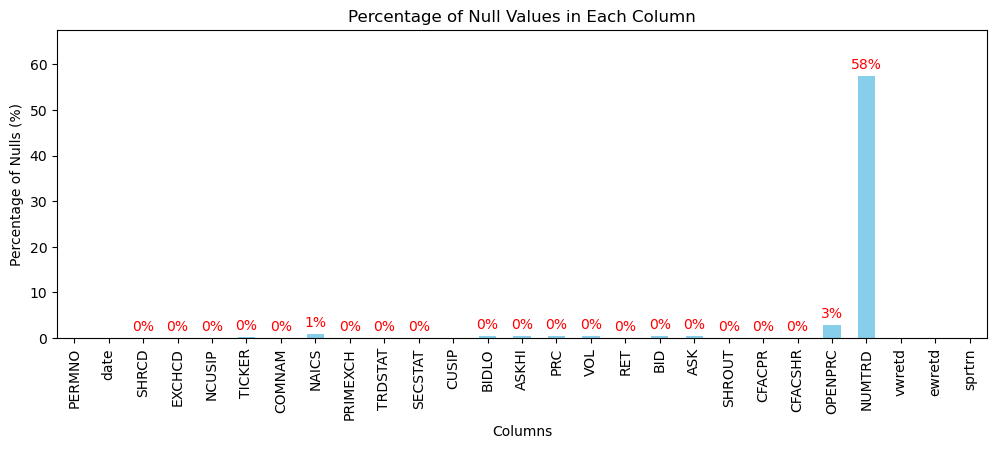

In [12]:
# Count the number of nulls in each column
null_counts = crsp_df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(crsp_df)
null_percentages = (null_counts / total_rows) * 100

# Plot the percentages as a bar plot
ax = null_percentages.plot(kind="bar", figsize=(12, 4), color="skyblue")
plt.title("Percentage of Null Values in Each Column")
plt.xlabel("Columns")
plt.ylim(0, max(null_percentages.values) + 10)
plt.ylabel("Percentage of Nulls (%)")

# Annotate the bars with the percentage values
for i, percentage in enumerate(null_percentages):
    if percentage != 0:
        ax.annotate(
            f"{percentage:.0f}%",
            xy=(i, percentage),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            color="red",
        )

plt.show()

# Review unique values and distribution in each remaining column


In [13]:
for column in crsp_df.columns:
    print("-" * 10, column, "-" * 10)
    print(crsp_df[column].nunique())
    print(crsp_df[column].value_counts())

---------- PERMNO ----------
12765
PERMNO
21259    1531
90731    1527
16780    1526
16437    1523
10065    1522
         ... 
15403       1
43095       1
92771       1
91431       1
13713       1
Name: count, Length: 12765, dtype: int64
---------- date ----------
1509
date
2022-10-13    9598
2022-09-30    9597
2022-10-17    9597
2022-10-06    9597
2022-09-29    9596
              ... 
2018-01-08    7339
2018-01-03    7339
2018-01-10    7338
2018-01-05    7338
2018-01-09    7337
Name: count, Length: 1509, dtype: int64
---------- SHRCD ----------
16
SHRCD
11.0    5944259
73.0    3673436
12.0    1141877
31.0     603387
44.0     424804
14.0     360856
18.0     272236
71.0     127196
48.0      53307
74.0      31661
72.0      20673
75.0       6027
41.0       3018
15.0       1519
21.0        764
10.0          2
Name: count, dtype: int64
---------- EXCHCD ----------
10
EXCHCD
 3.0     5382632
 1.0     3762010
 4.0     2424033
 5.0      652650
 2.0      400154
 0.0       39599
-1.0        3580


# Review SHRCD: security type

SHRCD is a two-digit code describing the type of shares traded. The first digit describes the type of security traded.


## B1. Fill SHRCD na with 00 as undefined


In [14]:
crsp_df["SHRCD"] = crsp_df["SHRCD"].fillna("00")

## B2. Split SHRCD to two columns [SHRCD_Type, SHRCD_Detail]


In [15]:
crsp_df[["SHRCD_Type", "SHRCD_Detail"]] = crsp_df["SHRCD"].astype(str).str.split("", expand=True).iloc[:, 1:3]

In [16]:
for column in ["SHRCD_Type", "SHRCD_Detail"]:
    print("-" * 10, column, "-" * 10)
    print(crsp_df[column].nunique())
    print(crsp_df[column].value_counts())

---------- SHRCD_Type ----------
6
SHRCD_Type
1    7720749
7    3858993
3     603387
4     481129
2        764
0        480
Name: count, dtype: int64
---------- SHRCD_Detail ----------
7
SHRCD_Detail
1    6678624
3    3673436
2    1162550
4     817321
8     325543
5       7546
0        482
Name: count, dtype: int64


## B3. Keep only records where SHRCD_type == 1 (Ordinary Common Shares)


In [17]:
og_len = len(crsp_df)
crsp_df = crsp_df[crsp_df["SHRCD_Type"] == "1"].reset_index(drop=True)
new_len = len(crsp_df)
print("num_records_removed: ", og_len - new_len)
print("num_records_kept: ", new_len)

num_records_removed:  4944753
num_records_kept:  7720749


# Review EXCHCD: Listed Exchange

EXCHCD is a code indicating the exchange on which a security is listed.


## C1. Fill EXCHCD na with 0 as "not listed in any exchange"


In [18]:
crsp_df["EXCHCD"] = pd.to_numeric(crsp_df["EXCHCD"], errors="coerce").fillna(0).astype(int)

## C2. Remove all records where EXCHCD < 0 (Halted, Suspended, or Not Trading)


In [19]:
og_len = len(crsp_df)
crsp_df = crsp_df[crsp_df["EXCHCD"] > 0].reset_index(drop=True)
new_len = len(crsp_df)
print("num_records_removed: ", og_len - new_len)
print("num_records_kept: ", new_len)

crsp_df["EXCHCD"] = crsp_df["EXCHCD"].astype(str)

num_records_removed:  41551
num_records_kept:  7679198


# Review PRIMEXCH: Primary Exchange

Primary Exchange is a one-character code which identifies the primary exchange on which the security trades.

https://www.crsp.org/wp-content/uploads/appendix/FlagType_EC.html


## D1. Fill PRIMEXCH na with X as "Unknown"


In [20]:
crsp_df["PRIMEXCH"] = crsp_df["PRIMEXCH"].fillna("X")

# Review TRDSTAT: Trading Status

Trading Status is a one-character field containing the trading status of securities.


## E1. Fill TRDSTAT na with X as "Unknown"


In [21]:
crsp_df["TRDSTAT"] = crsp_df["TRDSTAT"].fillna("X")

## E2. Keep only records where TRDSTAT == A (Active trading status)


In [22]:
og_len = len(crsp_df)
crsp_df = crsp_df[crsp_df["TRDSTAT"] == "A"].reset_index(drop=True)
new_len = len(crsp_df)
print("num_records_removed: ", og_len - new_len)
print("num_records_kept: ", new_len)

num_records_removed:  0
num_records_kept:  7679198


# Review SECSTAT: Security Status

Security Status is a one-character code that describes the status of a security.


## E1. Fill SECSTAT na with X as "Unknown"


In [23]:
crsp_df["SECSTAT"] = crsp_df["SECSTAT"].fillna("X")

## E2. Keep only records where SECSTAT == R (Regular Way)


In [24]:
og_len = len(crsp_df)
crsp_df = crsp_df[crsp_df["SECSTAT"] == "R"].reset_index(drop=True)
new_len = len(crsp_df)
print("num_records_removed: ", og_len - new_len)
print("num_records_kept: ", new_len)

num_records_removed:  0
num_records_kept:  7679198


# Take another look at the null analysis


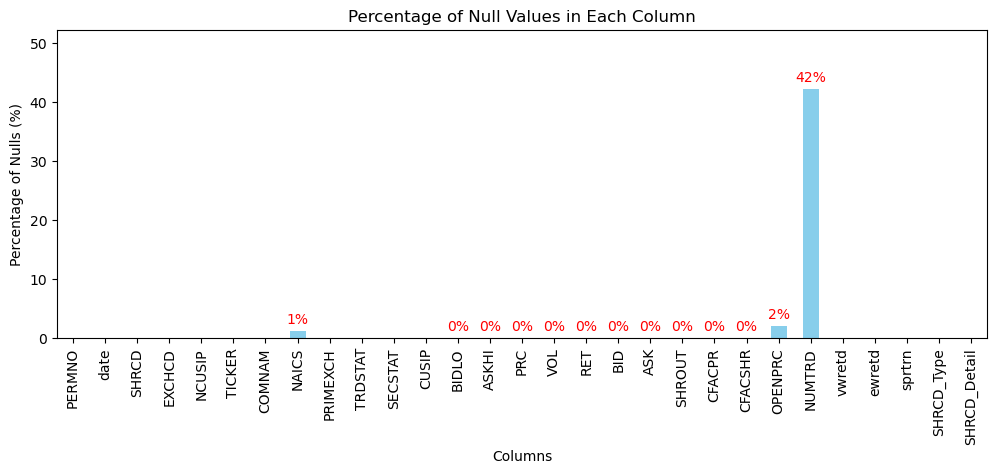

In [25]:
# Count the number of nulls in each column
null_counts = crsp_df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(crsp_df)
null_percentages = (null_counts / total_rows) * 100

# Plot the percentages as a bar plot
ax = null_percentages.plot(kind="bar", figsize=(12, 4), color="skyblue")
plt.title("Percentage of Null Values in Each Column")
plt.xlabel("Columns")
plt.ylim(0, max(null_percentages.values) + 10)
plt.ylabel("Percentage of Nulls (%)")

# Annotate the bars with the percentage values
for i, percentage in enumerate(null_percentages):
    if percentage != 0:
        ax.annotate(
            f"{percentage:.0f}%",
            xy=(i, percentage),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            color="red",
        )

plt.show()

# Review NAICS: North American Industry Classification System Code

North American Industry Classification System Code (NAICS) is an 6-character code used to group companies with similar products or services.

NAICS is a hierachical code, containing up to six digits: The first two fields, NAICS sectors, designate general categories of economic activity, the third field, sub-sector, further defines the sector, the fourth field is the industry group, the fifth field is the NAICS industry, and the sixth field represents the national industry (a zero in the 6th digit generally indicates that the NAICS industry and teh country industry are the same).


## F1. Fill NAICS na with 999999 as "Unknown"


In [26]:
crsp_df["NAICS"] = crsp_df["NAICS"].fillna("999999")

## F2. Split NAICS to two columns ['NAICS_Sector', 'NAICS_Secondary']


In [27]:
crsp_df["NAICS_Sector"] = crsp_df["NAICS"].astype(str).str[:2]
crsp_df["NAICS_Secondary"] = crsp_df["NAICS"].astype(str).str[2:]

In [28]:
for column in ["NAICS_Sector", "NAICS_Secondary"]:
    print("-" * 10, column, "-" * 10)
    print(crsp_df[column].nunique())
    print(crsp_df[column].value_counts())

---------- NAICS_Sector ----------
28
NAICS_Sector
52    1825643
33    1201230
32     941301
54     545264
51     491657
21     355642
53     321538
56     300820
42     256514
31     178603
44     174325
48     161630
62     150694
22     131369
55     118633
72     109493
23      96908
99      91217
45      91096
71      39479
81      32338
61      29367
11      22685
49       8926
92       2737
73         34
67         28
10         27
Name: count, dtype: int64
---------- NAICS_Secondary ----------
522
NAICS_Secondary
3910.0    571678
5412.0    533883
2110.0    440740
1110.0    297150
1210.0    272506
           ...  
1214.0        27
8100.0        27
4240.0        19
9121.0        13
9129.0         7
Name: count, Length: 522, dtype: int64


## F3. Clean-up the NAICS sector column to readable format

https://www.census.gov/naics/reference_files_tools/2022_NAICS_Manual.pdf


In [29]:
sector_dict = {
    "10": "Metal Mining",
    "11": "Agriculture, Forestry, Fishing and Hunting",
    "21": "Mining, Quarrying, and Oil and Gas Extraction",
    "22": "Utilities",
    "23": "Construction",
    "31": "Manufacturing",
    "32": "Manufacturing",
    "33": "Manufacturing",
    "42": "Wholesale Trade",
    "44": "Retail Trade",
    "45": "Retail Trade",
    "48": "Transportation and Warehousing",
    "49": "Transportation and Warehousing",
    "51": "Information",
    "52": "Finance and Insurance",
    "53": "Real Estate and Rental and Leasing",
    "54": "Professional, Scientific, and Technical Services",
    "55": "Management of Companies and Enterprises",
    "56": "Administrative and Support and Waste Management and Remediation Services",
    "61": "Educational Services",
    "62": "Health Care and Social Assistance",
    "67": "Holding And Other Investment Offices",
    "71": "Arts, Entertainment, and Recreation",
    "72": "Accommodation and Food Services",
    "73": "Business Services",
    "81": "Other Services (except Public Administration)",
    "92": "Public Administration",
    "99": "Unknown",
}

crsp_df["NAICS_Sector_Name"] = crsp_df["NAICS_Sector"].replace(sector_dict)

In [30]:
print(crsp_df["NAICS_Sector_Name"].value_counts())

NAICS_Sector_Name
Manufacturing                                                               2321134
Finance and Insurance                                                       1825643
Professional, Scientific, and Technical Services                             545264
Information                                                                  491657
Mining, Quarrying, and Oil and Gas Extraction                                355642
Real Estate and Rental and Leasing                                           321538
Administrative and Support and Waste Management and Remediation Services     300820
Retail Trade                                                                 265421
Wholesale Trade                                                              256514
Transportation and Warehousing                                               170556
Health Care and Social Assistance                                            150694
Utilities                                                 

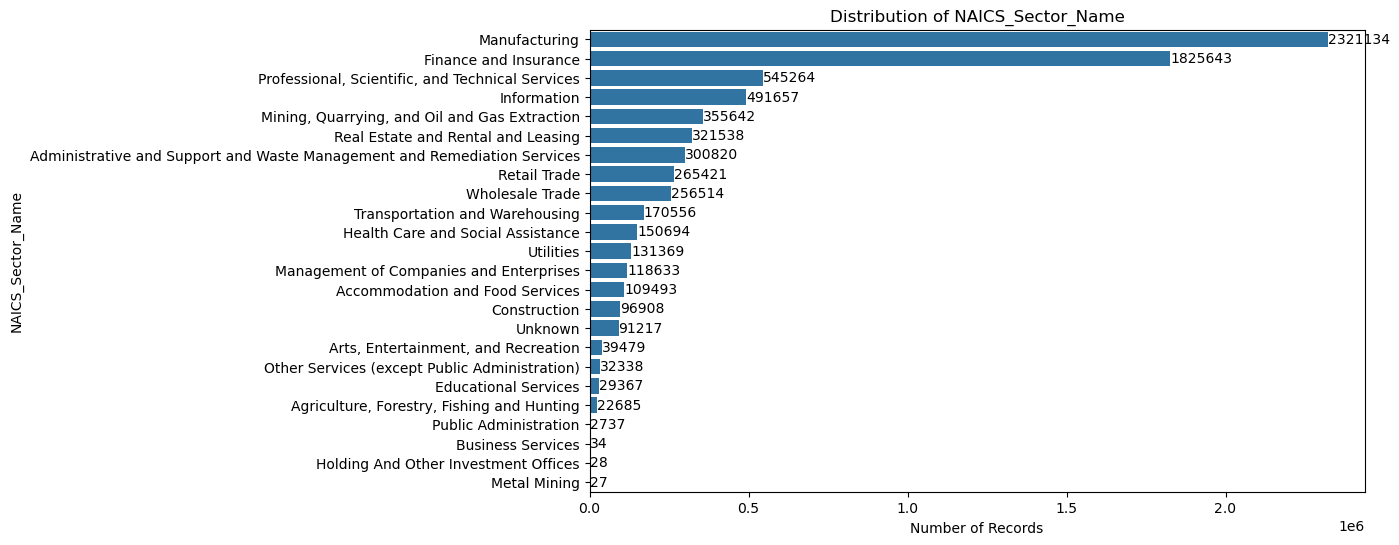

In [31]:
# Calculate the category counts and sort them in descending order
category_counts = crsp_df["NAICS_Sector_Name"].value_counts().sort_values(ascending=False)

# Plot the counts distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=crsp_df, y="NAICS_Sector_Name", order=category_counts.index)
plt.title("Distribution of NAICS_Sector_Name")
plt.xlabel("Number of Records")
plt.ylabel("NAICS_Sector_Name")

# Annotate the bars with the count values
for i, count in enumerate(category_counts):
    plt.text(count, i, f"{count}", ha="left", va="center", color="black")

plt.show()

# Review NUMTRD: Number of Trades

Daily: Number of Trades, Nasdaq contains the number of trades made on the Nasdaq Stock Market each date for a security. Trades on all exchanges are connected to Nasdaqs composite pricing network and all paper trades are included in the count. If the number of trades is unavailable, the field is set to 99.


## G1. Fill NUMTRD na with 99 as "Unknown"


In [32]:
crsp_df["NUMTRD"] = crsp_df["NUMTRD"].fillna("99")

# Review all remaining value related columns.


## H1. Drop all PERMNO with less than 128 days of return

In [33]:
og_permno = crsp_df['PERMNO'].nunique()
permno_counts = crsp_df['PERMNO'].value_counts()
permno_to_keep = permno_counts[permno_counts >= 128].index
crsp_df = crsp_df[crsp_df['PERMNO'].isin(permno_to_keep)].reset_index(drop=True)

assert crsp_df["PERMNO"].value_counts().min() >= 128

new_permno = crsp_df['PERMNO'].nunique()
print("num_PERMNO_og: ", og_permno)
print("num_PERMNO_removed: ", og_permno - new_permno)
print("num_PERMNO_kept: ", new_permno)

num_PERMNO_og:  7414
num_PERMNO_removed:  268
num_PERMNO_kept:  7146


## H2. Forward fill trading values

In [34]:
fill_cols = ["VOL", "SHROUT", 'ASKHI', 'ASK', 'BIDLO', 'BID', 'OPENPRC', 'PRC', "CFACPR", "CFACSHR", 'vwretd', 'ewretd', 'sprtrn']
crsp_df[fill_cols] = crsp_df[fill_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [35]:
print("before forward fill")
for col in fill_cols:
  print(f"number of nulls in column {col}: ", len(crsp_df[crsp_df[col].isnull()]))

before forward fill
number of nulls in column VOL:  2253
number of nulls in column SHROUT:  1681
number of nulls in column ASKHI:  2250
number of nulls in column ASK:  2294
number of nulls in column BIDLO:  2250
number of nulls in column BID:  2273
number of nulls in column OPENPRC:  161832
number of nulls in column PRC:  2250
number of nulls in column CFACPR:  1681
number of nulls in column CFACSHR:  1681
number of nulls in column vwretd:  0
number of nulls in column ewretd:  0
number of nulls in column sprtrn:  0


In [36]:
# pick an example for visual inspection
review_idx = crsp_df[crsp_df["PRC"].isnull()].index[0]
crsp_df[crsp_df["PRC"].isnull()].iloc[0]

PERMNO                                           10051
date                               2022-10-04 00:00:00
SHRCD                                             11.0
EXCHCD                                               1
NCUSIP                                        41043F20
TICKER                                            HNGR
COMNAM                                      HANGER INC
NAICS                                         621498.0
PRIMEXCH                                             N
TRDSTAT                                              A
SECSTAT                                              R
CUSIP                                         41043F20
BIDLO                                              NaN
ASKHI                                              NaN
PRC                                                NaN
VOL                                                NaN
RET                                                NaN
BID                                                NaN
ASK       

In [37]:
# forward fill
for col in fill_cols:
  crsp_df[col] = crsp_df.groupby('PERMNO')[col].ffill()

In [38]:
# visually inspect the example to ensure the price was forward filled correctly
crsp_df.iloc[review_idx-1 : review_idx+1]["PRC"]

7057   -12.365
7058   -12.365
Name: PRC, dtype: float64

In [39]:
print("after forward fill")
for col in fill_cols:
  print(f"number of nulls in column {col}: ", len(crsp_df[crsp_df[col].isnull()]))

after forward fill
number of nulls in column VOL:  134
number of nulls in column SHROUT:  0
number of nulls in column ASKHI:  135
number of nulls in column ASK:  141
number of nulls in column BIDLO:  135
number of nulls in column BID:  140
number of nulls in column OPENPRC:  2099
number of nulls in column PRC:  135
number of nulls in column CFACPR:  0
number of nulls in column CFACSHR:  0
number of nulls in column vwretd:  0
number of nulls in column ewretd:  0
number of nulls in column sprtrn:  0


## H3. If PRC is still NaN, that means it was the first day the stock was listed on the exchange, drop these records since we cannot calculate the return for these days

In [40]:
crsp_df.dropna(subset=["PRC"], inplace=True)
crsp_df.reset_index(drop=True, inplace=True)

In [41]:
print("after forward fill")
for col in fill_cols:
  print(f"number of nulls in column {col}: ", len(crsp_df[crsp_df[col].isnull()]))

after forward fill
number of nulls in column VOL:  0
number of nulls in column SHROUT:  0
number of nulls in column ASKHI:  0
number of nulls in column ASK:  6
number of nulls in column BIDLO:  0
number of nulls in column BID:  6
number of nulls in column OPENPRC:  1964
number of nulls in column PRC:  0
number of nulls in column CFACPR:  0
number of nulls in column CFACSHR:  0
number of nulls in column vwretd:  0
number of nulls in column ewretd:  0
number of nulls in column sprtrn:  0


## H4. If ASK, BID, OPENPRC are still NaN, fill them with 0

In [42]:
crsp_df["ASK"] = crsp_df["ASK"].fillna(0)
crsp_df["BID"] = crsp_df["BID"].fillna(0)
crsp_df["OPENPRC"] = crsp_df["OPENPRC"].fillna(0)

In [43]:
print("confirm forward fill was complete")
for col in fill_cols:
  assert len(crsp_df[crsp_df[col].isnull()]) == 0

confirm forward fill was complete


## H5. If RET is NaN, calculate the RET based on forward filled PRICE

In [44]:
crsp_df["RET"] = pd.to_numeric(crsp_df['RET'], errors='coerce')
print(f"number of nulls in column RET: ", len(crsp_df[crsp_df["RET"].isnull()]))

number of nulls in column RET:  4883


In [45]:
# pick an example for visual inspection
review_idx = crsp_df[crsp_df["RET"].isnull()].index[1]
crsp_df[crsp_df["RET"].isnull()].iloc[1]

PERMNO                                           10051
date                               2022-10-04 00:00:00
SHRCD                                             11.0
EXCHCD                                               1
NCUSIP                                        41043F20
TICKER                                            HNGR
COMNAM                                      HANGER INC
NAICS                                         621498.0
PRIMEXCH                                             N
TRDSTAT                                              A
SECSTAT                                              R
CUSIP                                         41043F20
BIDLO                                              5.0
ASKHI                                            19.73
PRC                                            -12.365
VOL                                                0.0
RET                                                NaN
BID                                                5.0
ASK       

In [46]:
# Calculate previous day's price for each PERMNO
crsp_df['prev_price'] = crsp_df.groupby('PERMNO')['PRC'].shift(1)

# Fill NaN values in the return column
crsp_df['RET'] = crsp_df.apply(
    lambda row: (row['PRC'] / row['prev_price'] - 1) if pd.isnull(row['RET']) else row['RET'], axis=1
)

In [47]:
# visually inspect the example to ensure the return was calculated correctly
display(crsp_df.iloc[review_idx-1 : review_idx+1]["PERMNO"]) 
display(crsp_df.iloc[review_idx-1 : review_idx+1]["PRC"])
display(crsp_df.iloc[review_idx-1 : review_idx+1]["prev_price"])
display(crsp_df.iloc[review_idx-1 : review_idx+1]["RET"])

crsp_df.drop(columns=['prev_price'], inplace=True)

7057    10051
7058    10051
Name: PERMNO, dtype: int64

7057   -12.365
7058   -12.365
Name: PRC, dtype: float64

7057    18.720
7058   -12.365
Name: prev_price, dtype: float64

7057   -0.339476
7058    0.000000
Name: RET, dtype: float64

## H6. If RET is still NaN, that means the previous price is not in this subset of the dataset, fill RET with 0

In [48]:
print(f"number of nulls in column RET: ", len(crsp_df[crsp_df["RET"].isnull()]))

number of nulls in column RET:  2704


In [49]:
crsp_df["RET"] = crsp_df["RET"].fillna(0)

In [50]:
assert len(crsp_df[crsp_df["RET"].isnull()]) == 0

## H7. Cast to appropriate type

In [51]:
int_cols = ["VOL", "SHROUT", "NUMTRD"]
float_cols = [
    "ASKHI",
    "ASK",
    "BIDLO",
    "BID",
    "OPENPRC",
    "PRC",
    "RET",
    "CFACPR",
    "CFACSHR",
    "vwretd",
    "ewretd",
    "sprtrn",
]
str_cols = [
    "PERMNO",
    "NCUSIP",
    "CUSIP",
    "TICKER",
    "SHRCD",
    "SHRCD_Type",
    "SHRCD_Detail",
    "EXCHCD",
    "COMNAM",
    "PRIMEXCH",
    "TRDSTAT",
    "SECSTAT",
    "NAICS",
    "NAICS_Sector",
    "NAICS_Secondary",
]

In [52]:
crsp_df[int_cols] = crsp_df[int_cols].astype(int)
crsp_df[float_cols] = crsp_df[float_cols].astype(float)
crsp_df[str_cols] = crsp_df[str_cols].astype(str)

## H8. Remove outliers, PERMNO that had more than 10 days of over 100% or under -50% returns

Return is calculated using (close_price/previous_close_price)-1.

In [53]:
# Define the conditions
over_100_percent = crsp_df["RET"] > 1.0
under_50_percent = crsp_df["RET"] < -0.5

# Create a boolean mask for the conditions
condition_mask = over_100_percent | under_50_percent

# Count the number of days each permno_id satisfies the condition
permno_counts = crsp_df[condition_mask].groupby('PERMNO').size()

In [54]:
# Filter out PERMNO with more than 10 days satisfying the condition
to_remove = permno_counts[permno_counts > 10].index
print("num_PERMNO_removed: ", len(to_remove))

# Filter the DataFrame to exclude those PERMNO
og_len = len(crsp_df)
crsp_df = crsp_df[~crsp_df['PERMNO'].isin(to_remove)]
new_len = len(crsp_df)
print("num_records_removed: ", og_len - new_len)
print("num_records_kept: ", new_len)

num_PERMNO_removed:  1
num_records_removed:  1509
num_records_kept:  7660038


# Take another look at the null analysis


In [55]:
# Count the number of nulls in each column
null_counts = crsp_df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(crsp_df)
null_percentages = (null_counts / total_rows) * 100

assert null_percentages.min() == 0.0

## I1. Remove duplicates


In [56]:
og_len = len(crsp_df)
crsp_df = crsp_df.drop_duplicates()
new_len = len(crsp_df)
print("num_records_removed: ", og_len - new_len)
print("num_records_kept: ", new_len)

num_records_removed:  1124
num_records_kept:  7658914


## I2. Confirm each PERMNO contains at most num_days records (each PERMNO only has one record per day)


In [57]:
num_days = crsp_df["date"].nunique()

In [58]:
assert crsp_df["PERMNO"].value_counts().max() <= num_days

## I3. Rename & Reorder all columns


In [59]:
rename_dict = {
    "date": "date",
    "PERMNO": "permno_id",
    "NCUSIP": "ncusip_id",
    "CUSIP": "cusip_id",
    "TICKER": "ticker",
    "SHRCD": "share_code",
    "SHRCD_Type": "share_code_type",
    "SHRCD_Detail": "share_code_detail",
    "EXCHCD": "exchange_code",
    "COMNAM": "company_name",
    "PRIMEXCH": "primary_exchange",
    "TRDSTAT": "trading_status",
    "SECSTAT": "security_status",
    "NAICS": "naics",
    "NAICS_Sector": "naics_sector",
    "NAICS_Sector_Name": "naics_sector_name",
    "NAICS_Secondary": "naics_secondary",
    "ASKHI": "ask_or_high_price",
    "ASK": "ask_price",
    "BIDLO": "bid_or_low_price",
    "BID": "bid_price",
    "OPENPRC": "open_price",
    "PRC": "close_price",
    "RET": "return",
    "VOL": "volume",
    "SHROUT": "shares_outstanding",
    "NUMTRD": "num_trades",
    "CFACPR": "factor_to_adjust_price",
    "CFACSHR": "factor_to_adjust_shares",
    "vwretd": "value_weighted_return",
    "ewretd": "equal_weighted_return",
    "sprtrn": "return_on_SP_index",
}

crsp_df = crsp_df.rename(columns=rename_dict)
crsp_df = crsp_df[list(rename_dict.values())]

# Take a final look at the columns


In [60]:
crsp_df.columns

Index(['date', 'permno_id', 'ncusip_id', 'cusip_id', 'ticker', 'share_code',
       'share_code_type', 'share_code_detail', 'exchange_code', 'company_name',
       'primary_exchange', 'trading_status', 'security_status', 'naics',
       'naics_sector', 'naics_sector_name', 'naics_secondary',
       'ask_or_high_price', 'ask_price', 'bid_or_low_price', 'bid_price',
       'open_price', 'close_price', 'return', 'volume', 'shares_outstanding',
       'num_trades', 'factor_to_adjust_price', 'factor_to_adjust_shares',
       'value_weighted_return', 'equal_weighted_return', 'return_on_SP_index'],
      dtype='object')

In [61]:
crsp_df.dtypes

date                       datetime64[ns]
permno_id                          object
ncusip_id                          object
cusip_id                           object
ticker                             object
share_code                         object
share_code_type                    object
share_code_detail                  object
exchange_code                      object
company_name                       object
primary_exchange                   object
trading_status                     object
security_status                    object
naics                              object
naics_sector                       object
naics_sector_name                  object
naics_secondary                    object
ask_or_high_price                 float64
ask_price                         float64
bid_or_low_price                  float64
bid_price                         float64
open_price                        float64
close_price                       float64
return                            

In [62]:
crsp_len = len(crsp_df)
crsp_cols = len(crsp_df.columns)
print("number of records:", crsp_len)
print("number of columns:", crsp_cols)

number of records: 7658914
number of columns: 32


# Review unique values and distribution in each remaining column


In [63]:
for column in crsp_df.columns:
    print("-" * 10, column, "-" * 10)
    print(crsp_df[column].nunique())
    print(crsp_df[column].value_counts())

---------- date ----------
1509
date
2022-05-17    5890
2022-05-18    5890
2022-05-19    5889
2022-05-13    5889
2022-05-16    5888
              ... 
2018-01-04    4432
2018-01-05    4432
2018-01-08    4432
2018-01-03    4432
2018-01-02    4431
Name: count, Length: 1509, dtype: int64
---------- permno_id ----------
7145
permno_id
93436    1509
10026    1509
10028    1509
10032    1509
10044    1509
         ... 
24012     129
23994     128
23978     128
23970     128
89681     127
Name: count, Length: 7145, dtype: int64
---------- ncusip_id ----------
9047
ncusip_id
88160R10    1509
46603210    1509
78513510    1509
12503M10    1509
72913210    1509
            ... 
74102L20       1
92535P87       1
05338F30       1
45784G10       1
75811Y10       1
Name: count, Length: 9047, dtype: int64
---------- cusip_id ----------
7147
cusip_id
88160R10      1509
46603210      1509
29402E10      1509
72913210      1509
77467X10      1509
              ... 
G3398L11       128
50012A10       128
80

# Save the cleaned df as csv & parquet


In [64]:
crsp_df.to_csv(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean.csv",
    index=False,
)
crsp_df.to_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean.parquet")

In [65]:
reload = pd.read_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean.parquet")
assert crsp_df.equals(reload)

reload.head()

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,close_price,return,volume,shares_outstanding,num_trades,factor_to_adjust_price,factor_to_adjust_shares,value_weighted_return,equal_weighted_return,return_on_SP_index
0,2018-01-02,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,149.17999,-0.017454,190618,18668,1036,1.0,1.0,0.008505,0.011232,0.008303
1,2018-01-03,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,147.69000,-0.009988,63693,18668,1283,1.0,1.0,0.005856,0.005103,0.006399
2,2018-01-04,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,149.73000,0.013813,127552,18668,1138,1.0,1.0,0.004001,0.005272,0.004029
3,2018-01-05,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,148.30000,-0.009550,44647,18668,745,1.0,1.0,0.005804,0.003880,0.007034
4,2018-01-08,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,148.41000,0.000742,55014,18668,990,1.0,1.0,0.001816,0.000584,0.001662


# Upload the parquet to s3


In [66]:
s3.upload_file(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean.parquet",
    bucket,
    "CRSP/crsp_2018-2023_clean.parquet",
)

In [67]:
reload_path = s3_download("CRSP/crsp_2018-2023_clean.parquet")

In [68]:
reload = pd.read_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean.parquet")
assert crsp_df.equals(reload)

reload.head()

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,close_price,return,volume,shares_outstanding,num_trades,factor_to_adjust_price,factor_to_adjust_shares,value_weighted_return,equal_weighted_return,return_on_SP_index
0,2018-01-02,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,149.17999,-0.017454,190618,18668,1036,1.0,1.0,0.008505,0.011232,0.008303
1,2018-01-03,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,147.69000,-0.009988,63693,18668,1283,1.0,1.0,0.005856,0.005103,0.006399
2,2018-01-04,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,149.73000,0.013813,127552,18668,1138,1.0,1.0,0.004001,0.005272,0.004029
3,2018-01-05,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,148.30000,-0.009550,44647,18668,745,1.0,1.0,0.005804,0.003880,0.007034
4,2018-01-08,10026,46603210,46603210,JJSF,11.0,1,1,3,J & J SNACK FOODS CORP,...,148.41000,0.000742,55014,18668,990,1.0,1.0,0.001816,0.000584,0.001662
